<a href="https://colab.research.google.com/github/tomgalili/deep-learning-course/blob/main/Copy_of_Assignment1_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1. Music Century Classification

**Assignment Responsible**: Natalie Lang.

In this assignment, we will build models to predict which
**century** a piece of music was released.  We will be using the "YearPredictionMSD Data Set"
based on the Million Song Dataset. The data is available to download from the UCI 
Machine Learning Repository. Here are some links about the data:

- https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd
- http://millionsongdataset.com/pages/tasks-demos/#yearrecognition

Note that you are note allowed to import additional packages **(especially not PyTorch)**. One of the objectives is to understand how the training procedure actually operates, before working with PyTorch's autograd engine which does it all for us.


## Question 1. Data (21%)

Start by setting up a Google Colab notebook in which to do your work.
Since you are working with a partner, you might find this link helpful:

- https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb

The recommended way to work together is pair coding, where you and your partner are sitting together and writing code together. 

To process and read the data, we use the popular `pandas` package for data analysis.

In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

Now that your notebook is set up, we can load the data into the notebook. The code below provides
two ways of loading the data: directly from the internet, or through mounting Google Drive.
The first method is easier but slower, and the second method is a bit involved at first, but
can save you time later on. You will need to mount Google Drive for later assignments, so we recommend
figuring how to do that now.

Here are some resources to help you get started:

- http.://colab.research.google.com/notebooks/io.ipynb

In [2]:
load_from_drive = False

if not load_from_drive:
  csv_path = "http://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip"
else:
  from google.colab import drive
  drive.mount('/content/gdrive')
  csv_path = '/content/gdrive/My Drive/YearPredictionMSD.txt.zip' # TODO - UPDATE ME WITH THE TRUE PATH!

t_label = ["year"]
x_labels = ["var%d" % i for i in range(1, 91)]
df = pandas.read_csv(csv_path, names=t_label + x_labels)

Now that the data is loaded to your Colab notebook, you should be able to display the Pandas
DataFrame `df` as a table:

In [3]:
df

,year,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,...,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68,var69,var70,var71,var72,var73,var74,var75,var76,var77,var78,var79,var80,var81,var82,var83,var84,var85,var86,var87,var88,var89,var90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.0500

To set up our data for classification, we'll use the "year" field to represent
whether a song was released in the 20-th century. In our case `df["year"]` will be 1 if
the year was released after 2000, and 0 otherwise.

In [4]:
df["year"] = df["year"].map(lambda x: int(x > 2000))

In [5]:
df.head(20)

,year,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,...,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68,var69,var70,var71,var72,var73,var74,var75,var76,var77,var78,var79,var80,var81,var82,var83,var84,var85,var86,var87,var88,var89,var90
0,1,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,1,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,1,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,1,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,1,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.05003,-56.51161,-34

### Part (a) -- 7%

The data set description text asks us to respect the below train/test split to
avoid the "producer effect". That is, we want to make sure that no song from a single artist
ends up in both the training and test set.

Explain why it would be problematic to have
some songs from an artist in the training set, and other songs from the same artist in the
test set. (Hint: Remember that we want our test accuracy to predict how well the model
will perform in practice on a song it hasn't learned about.)

In [6]:
df_train = df[:463715]
df_test = df[463715:]

# convert to numpy
train_xs = df_train[x_labels].to_numpy()
train_ts = df_train[t_label].to_numpy()
test_xs = df_test[x_labels].to_numpy()
test_ts = df_test[t_label].to_numpy()

# Write your explanation here
'''We want our model to function best in the outside world,and we want the accuracy be reliable.
The training set can give a measure of the model's success - if the model manages to find patterns in the training set that are also true for the test set,
it is a sign that the model has managed to find rules that can be
also true for new examples to come. We want to evaluate our model correctly so to make sure that we do it, we want to know how well the model will perform in practice on
 a song it hasn't learned about.
Using some songs from an artist in the training set, and other songs from the same artist in the test set
can lead us to a situation where the model will learn specific featues of the singer
such as his voice, and will predict the decade according to the singer voice.
In that situation, we will indeed get a good test accuracy because the singer's songs are in the test data,so the model will predict correctly,
but that does not mean that the model will perfom the same on different singers and because of this scenario,
it's problematic to have some songs from an artist in the training set, and other songs
from the same artist in the test set because the test data won’t represent the true performance of the model'''

"We want our model to function best in the outside world,and we want the accuracy be reliable.\nThe training set can give a measure of the model's success - if the model manages to find patterns in the training set that are also true for the test set,\nit is a sign that the model has managed to find rules that can be\nalso true for new examples to come. We want to evaluate our model correctly so to make sure that we do it, we want to know how well the model will perform in practice on\n a song it hasn't learned about.\nUsing some songs from an artist in the training set, and other songs from the same artist in the test set\ncan lead us to a situation where the model will learn specific featues of the singer\nsuch as his voice, and will predict the decade according to the singer voice.\nIn that situation, we will indeed get a good test accuracy because the singer's songs are in the test data,so the model will predict correctly,\nbut that does not mean that the model will perfom the same

### Part (b) -- 7%

It can be beneficial to **normalize** the columns, so that each column (feature)
has the *same* mean and standard deviation.

In [7]:
feature_means = df_train.mean()[1:].to_numpy() # the [1:] removes the mean of the "year" field
feature_stds  = df_train.std()[1:].to_numpy()

train_norm_xs = (train_xs - feature_means) / feature_stds
test_norm_xs = (test_xs - feature_means) / feature_stds

Notice how in our code, we normalized the test set using the *training data means and standard deviations*.
This is *not* a bug.

Explain why it would be improper to compute and use test set means
and standard deviations. (Hint: Remember what we want to use the test accuracy to measure.)

In [8]:
'''In the outside world it is not possible to collect all the songs and find them means and standard deviations,
and we want our model to represent the world reliably.
The idea is that test data is supposed to mimic new, previously unseen data after training. 
If we normalize the test data separately we can cause data leakage,
meaing we are introducing future information into the training explanatory variables (for example the mean and variance).
Therefore, we should perform feature normalisation over the training data,
and then perform normalisation on testing data by using the mean and variance of training explanatory variables .
In this way, we can test and evaluate whether our model can generalize well to new, unseen data points.'''


'In the outside world it is not possible to collect all the songs and find them means and standard deviations,\nand we want our model to represent the world reliably.\nThe idea is that test data is supposed to mimic new, previously unseen data after training. \nIf we normalize the test data separately we can cause data leakage,\nmeaing we are introducing future information into the training explanatory variables (for example the mean and variance).\nTherefore, we should perform feature normalisation over the training data,\nand then perform normalisation on testing data by using the mean and variance of training explanatory variables .\nIn this way, we can test and evaluate whether our model can generalize well to new, unseen data points.'

### Part (c) -- 7%

Finally, we'll move some of the data in our training set into a validation set.

Explain why we should limit how many times we use the test set, and that we should use the validation
set during the model building process.

In [9]:
# shuffle the training set
reindex = np.random.permutation(len(train_xs))
train_xs = train_xs[reindex]
train_norm_xs = train_norm_xs[reindex]
train_ts = train_ts[reindex]

# use the first 50000 elements of `train_xs` as the validation set
train_xs, val_xs           = train_xs[50000:], train_xs[:50000]
train_norm_xs, val_norm_xs = train_norm_xs[50000:], train_norm_xs[:50000]
train_ts, val_ts           = train_ts[50000:], train_ts[:50000]

# Write your explanation here
'''itamar work'''

'itamar work'

## Part 2. Classification (79%)

We will first build a *classification* model to perform decade classification.
These helper functions are written for you. All other code that you write in this section should be vectorized whenever possible (i.e., avoid unnecessary loops).

In [10]:
def sigmoid(z):
  return 1 / (1 + np.exp(-z))
    
def cross_entropy(t, y):
  eps = 1e-07
  return -t * np.log(y+eps) - (1 - t) * np.log(1- y + eps)

def cost(y, t):
  return np.mean(cross_entropy(t, y))

def get_accuracy(y, t):
  acc = 0
  N = 0
  for i in range(len(y)):
    N += 1
    if (y[i] >= 0.5 and t[i] == 1) or (y[i] < 0.5 and t[i] == 0):
      acc += 1
  return acc / N

### Part (a) -- 7%

Write a function `pred` that computes the prediction `y` based on logistic regression, i.e., a single layer with weights `w` and bias `b`. The output is given by: 
\begin{equation}
y = \sigma({\bf w}^T {\bf x} + b),
\end{equation}
where the value of $y$ is an estimate of the probability that the song is released in the current century, namely ${\rm year} =1$.

In [11]:
def pred(w, b, X):
  """
  Returns the prediction `y` of the target based on the weights `w` and scalar bias `b`.

  Preconditions: np.shape(w) == (90,)
                 type(b) == float
                 np.shape(X) = (N, 90) for some N

  >>> pred(np.zeros(90), 1, np.ones([2, 90]))
  array([0.73105858, 0.73105858]) # It's okay if your output differs in the last decimals
  """
  # Your code goes here 
  z=np.dot(X,w)+b
  y = sigmoid(z)
  return y

### Part (b) -- 7%

Write a function `derivative_cost` that computes and returns the gradients 
$\frac{\partial\mathcal{L}}{\partial {\bf w}}$ and
$\frac{\partial\mathcal{L}}{\partial b}$. Here, `X` is the input, `y` is the prediction, and `t` is the true label.




In [12]:
def derivative_cost(X, y, t):
  """
  Returns a tuple containing the gradients dLdw and dLdb.

  Precondition: np.shape(X) == (N, 90) for some N
                np.shape(y) == (N,)
                np.shape(t) == (N,)

  Postcondition: np.shape(dLdw) = (90,)
           type(dLdb) = float
  """
  # Your code goes here
  N = len(y)
  eps = 1e-07
  DL_Dy = (-t/(y+eps)+(1-t)/(1- y + eps))/N # We want to avoid the option of log(0)
  Dy_Db= y*(1-y)
  Dy_Dw = Dy_Db*X.T
  DL_Dw = np.dot(Dy_Dw,DL_Dy)
  DL_Db = np.dot(Dy_Db,DL_Dy)
  return (DL_Dw , DL_Db)

 

# **Explenation on Gradients**




**Add here an explaination on how the gradients are computed**:

Write your explanation here. Use Latex to write mathematical expressions. [Here is a brief tutorial on latex for notebooks.](https://www.math.ubc.ca/~pwalls/math-python/jupyter/latex/)



We calculate $\frac{\partial L}{\partial w},\frac{\partial L}{\partial b}$ , for this calculate we will use the chain rule:

$L(w,b,X,t)=-\frac{1}{N}\sum_{n=1}^{N}t_n\log(y_n)+(1-t_n)\log(1-y_n)=-\frac{1}{N}( t\cdot\log(y) + (1-t)\cdot\log(1-y)) $

So $\frac{\partial L}{\partial w}= \frac{\partial L}{\partial y}\cdot \frac{\partial y}{\partial w} $ , and $\frac{\partial L}{\partial b}= \frac{\partial L}{\partial y}\cdot \frac{\partial y}{\partial b} $ 

When the derivatives are:

$\frac{\partial L}{\partial y}=-\frac{1}{N}(\frac{t}{y}-\frac{1-t}{1-y} )=-\frac{1}{N}\frac{t-y}{y \cdot (1-y)}$

$\sigma(z) = \frac{1}{1+e^{-z}}$ ------> $\sigma'(z) = -\frac{1}{(1+e^{-z})^2}\cdot e^z\cdot (-1) = \sigma(z)(1-\sigma(z))$ ------>

$\frac{\partial y}{\partial b}=\frac{\partial y}{\partial z} \frac{\partial z}{\partial b} =\sigma'(z)\cdot1=\sigma(z)(1-\sigma(z))=y(1-y)$

$\frac{\partial y}{\partial w}=\frac{\partial y}{\partial z} \frac{\partial z}{\partial w} =\sigma'(z)X=(\sigma(z\cdot)(1-\sigma(z)))X=(y\cdot(1-y))X$

### Part (c) -- 7%

We can check that our derivative is implemented correctly using the finite difference rule. In 1D, the
finite difference rule tells us that for small $h$, we should have

$$\frac{f(x+h) - f(x)}{h} \approx f'(x)$$

Show that $\frac{\partial\mathcal{L}}{\partial b}$  is implement correctly
by comparing the result from `derivative_cost` with the empirical cost derivative computed using the above numerical approximation.


In [13]:
def analyt_deriv(w,b,t,X,variable,h):
  y = pred(w, b, X)
  L = cost(y,t)
  if variable=='b':
    y_eps=pred(w,b+h,X)
    L_eps=cost(y_eps,t)
    de=(L_eps-L)/h
  elif variable=='w':
    L_eps=np.zeros(len(w))
    de=np.zeros(len(w))
    for i in range(len(w)):
      # Compute cost of w[i] + h
      w_eps = np.copy(w)
      w_eps[i] = w_eps[i] + h
      y_eps=pred(w_eps,b,X)
      L_eps[i]=cost(y_eps,t)
      de[i] = (L_eps[i]-L)/h

  else:
    raise Exception('variable_to_check: {} is not define - has to be b or w'.format(parameter_to_check))


  return de



In [14]:
b = np.random.rand(1)
w = np.random.rand(90)
h = 10**(-5);
t = (train_ts[:3]).squeeze()
X =train_norm_xs[:3]
y =pred(w, b, X)
DL_Dw ,DL_Db = derivative_cost(X,y,t)

In [15]:
analyt_deriviate = analyt_deriv(w,b,t,X,'b',h)
print("The analytical results is ", analyt_deriviate)
print("The algorithm results is ", DL_Db)

diff_res = analyt_deriviate - DL_Db
print("The error between the results:",diff_res) #Tiny error between the derivatives that we found

The analytical results is  -0.005147630321999941
The algorithm results is  -0.00514765661034768
The error between the results: 2.6288347739107654e-08


### Part (d) -- 7%

Show that $\frac{\partial\mathcal{L}}{\partial {\bf w}}$  is implement correctly.

In [16]:
# Your code goes here. You might find this below code helpful: but it's
# up to you to figure out how/why, and how to modify the code
analyt_deriviate = analyt_deriv(w,b,t,X,'w',h)
print("The analytical results is ", analyt_deriviate)
print("The algorithm results is ", DL_Dw)
mean_absolute_error = np.mean(abs(analyt_deriviate - DL_Dw))
print("The mean absolute error between analytical and our algorithm is" ,  mean_absolute_error)


The analytical results is  [-0.11722061 -0.14362277  0.06719257  0.33302298  0.0160591  -0.09454647
  0.14267996  0.17218692 -0.16955933 -0.22179226  0.63586848  0.38799575
  0.79072446  0.10236079  0.17472533 -0.0896226  -0.21972279  0.02085738
 -0.08978292  0.03127283  0.19152966  0.00893119 -0.24864326  0.02494453
  0.33314762 -0.0111611   0.15116951 -0.1378276   0.0751125   0.00504617
 -0.1994878  -0.04992552  0.01389875 -0.05140703  0.08693458  0.71282472
 -0.06740477  0.00288521  0.00224683 -0.11107325 -0.0614365  -0.06007427
  0.01002892 -0.23960788  0.06877539  0.25260498 -0.42285718 -0.66733895
  0.16589788 -0.08813312 -0.1173026  -0.33277008  0.15480234 -0.28759764
 -0.19193865 -0.16001291  0.46007256  0.08758382  0.38233653 -0.02397517
 -0.07949165  0.16469236 -0.54792973  0.02890988 -0.00174628  0.52536293
  0.44162137  0.15152896  0.05316605  0.33816396 -0.07653298  0.35351429
  0.00712969 -0.11178279  0.11036261 -0.17739153  0.36380544  0.00320653
  0.45076145  0.06985445

### Part (e) -- 7%

Now that you have a gradient function that works, we can actually run gradient descent. 
Complete the following code that will run stochastic: gradient descent training:

In [17]:
def run_gradient_descent(w0, b0, mu=0.1, batch_size=100, max_iters=100):
  """Return the values of (w, b) after running gradient descent for max_iters.
  We use:
    - train_norm_xs and train_ts as the training set
    - val_norm_xs and val_ts as the test set
    - mu as the learning rate
    - (w0, b0) as the initial values of (w, b)

  Precondition: np.shape(w0) == (90,)
                type(b0) == float
 
  Postcondition: np.shape(w) == (90,)
                 type(b) == float
  """
  w = w0
  b = b0
  iter = 0
  accuracy=[]
  loss=[]


  while iter < max_iters:
    # shuffle the training set (there is code above for how to do this)
    print(iter)
    shuffle_index = np.random.permutation(len(train_norm_xs))
    train_norm_xs_shuffeld = train_norm_xs[shuffle_index]
    train_ts_shuffeld= train_ts[shuffle_index]

    for i in range(0, len(train_norm_xs), batch_size): # iterate over each minibatch
      # minibatch that we are working with:
      X = train_norm_xs_shuffeld[i:(i + batch_size)]
      t = train_ts_shuffeld[i:(i + batch_size), 0]

      # since len(train_norm_xs) does not divide batch_size evenly, we will skip over
      # the "last" minibatch
      if np.shape(X)[0] != batch_size:
        continue
      

      # compute the prediction
      y=pred(w,b,X)
      # update w and b
      DL_Dw,DL_Db = derivative_cost(X,y,t)
      w -= mu*DL_Dw
      b -= mu*DL_Db
      # increment the iteration count
      iter += 1

      # increment the iteration count
      iter += 1
      # compute and print the *validation* loss and accuracy
      if (iter % 10 == 0):
          y_val=pred(w,b,val_norm_xs)
          val_cost = cost(y_val,val_ts.squeeze())
          val_acc = get_accuracy(y_val,val_ts.squeeze())
          print("Iter %d. [Val Acc %.0f%%, Loss %f]" % (iter, val_acc * 100, val_cost))
          loss.append(val_cost)
          accuracy.append(val_acc)
      if iter >= max_iters:
      
        break

      # Think what parameters you should return for further use
      
  return w,b,loss,accuracy



### Part (f) -- 7%

Call `run_gradient_descent` with the weights and biases all initialized to zero.
Show that if the learning rate $\mu$ is too small, then convergence is slow.
Also, show that if $\mu$ is too large, then the optimization algorirthm does not converge. The demonstration should be made using plots showing these effects.

mu= 0.05 :
0
Iter 10. [Val Acc 51%, Loss 3.049086]
Iter 20. [Val Acc 52%, Loss 2.973232]
Iter 30. [Val Acc 52%, Loss 2.897170]
Iter 40. [Val Acc 52%, Loss 2.832593]
Iter 50. [Val Acc 52%, Loss 2.766043]
Iter 60. [Val Acc 52%, Loss 2.711586]
Iter 70. [Val Acc 52%, Loss 2.654000]
Iter 80. [Val Acc 52%, Loss 2.609826]
Iter 90. [Val Acc 53%, Loss 2.559142]
Iter 100. [Val Acc 53%, Loss 2.511817]
~~~~~~~~~~~~~~~~~~~~~~~~~
mu= 0.6 :
0
Iter 10. [Val Acc 54%, Loss 2.203429]
Iter 20. [Val Acc 55%, Loss 1.960441]
Iter 30. [Val Acc 57%, Loss 1.723262]
Iter 40. [Val Acc 58%, Loss 1.547858]
Iter 50. [Val Acc 60%, Loss 1.409073]
Iter 60. [Val Acc 61%, Loss 1.294347]
Iter 70. [Val Acc 61%, Loss 1.167251]
Iter 80. [Val Acc 63%, Loss 1.087598]
Iter 90. [Val Acc 64%, Loss 1.023751]
Iter 100. [Val Acc 64%, Loss 0.967991]
~~~~~~~~~~~~~~~~~~~~~~~~~
mu= 7 :
0
Iter 10. [Val Acc 64%, Loss 1.408433]
Iter 20. [Val Acc 58%, Loss 2.355871]
Iter 30. [Val Acc 64%, Loss 2.216792]
Iter 40. [Val Acc 66%, Loss 1.601078]

Text(0.5, 1.0, 'The affect of mu on the convergence')

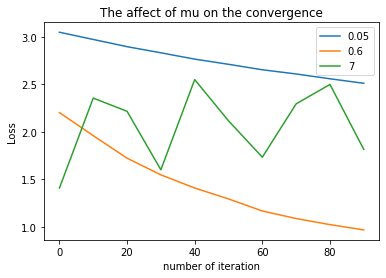

In [24]:
w0 = np.random.randn(90)
b0 = np.random.randn(1)[0]

# Write your code here
mus=[0.05,0.6,7]
for mu in mus:
    print("mu=",mu,":")
    w,b,loss,accuracy=run_gradient_descent(w0,b0,mu)
    print("~~~~~~~~~~~~~~~~~~~~~~~~~")
    plt.plot(range(0,100,10),loss)
plt.legend(mus,loc='upper right')
plt.xlabel("number of iteration")
plt.ylabel("Loss")
plt.title("The affect of mu on the convergence")

**Explain and discuss your results here:**
We can see in the graph that if the learning rate is set too high, for example we toke  μ=7  - it cause undesirable divergent behavior in our loss function because the steps do oscillation and do not converge to the local minima.

If the learning rate is set too low, for example we toke  μ=0.05  , the training progress is very slowly because in each epoch we are making very tiny updates to the weights.

As we can see, for regular learning rate such as  μ=1  we can tell that we got covergence and the covergence is not too slow, we get good covergence.

### Part (g) -- 7%

Find the optimial value of ${\bf w}$ and $b$ using your code. Explain how you chose
the learning rate $\mu$ and the batch size. Show plots demostrating good and bad behaviours.

batch_size= 10 :
0
Iter 10. [Val Acc 56%, Loss 2.157357]
Iter 20. [Val Acc 56%, Loss 2.225350]
Iter 30. [Val Acc 56%, Loss 2.122145]
Iter 40. [Val Acc 58%, Loss 2.033884]
Iter 50. [Val Acc 59%, Loss 1.886989]
Iter 60. [Val Acc 59%, Loss 1.894869]
Iter 70. [Val Acc 61%, Loss 1.753090]
Iter 80. [Val Acc 62%, Loss 1.596985]
Iter 90. [Val Acc 63%, Loss 1.463675]
Iter 100. [Val Acc 63%, Loss 1.438212]
~~~~~~~~~~~~~~~~~~~~~
batch_size= 60 :
0
Iter 10. [Val Acc 65%, Loss 1.227072]
Iter 20. [Val Acc 65%, Loss 1.113515]
Iter 30. [Val Acc 66%, Loss 1.016700]
Iter 40. [Val Acc 66%, Loss 0.973450]
Iter 50. [Val Acc 65%, Loss 0.945308]
Iter 60. [Val Acc 66%, Loss 0.884966]
Iter 70. [Val Acc 67%, Loss 0.834584]
Iter 80. [Val Acc 68%, Loss 0.787171]
Iter 90. [Val Acc 68%, Loss 0.760852]
Iter 100. [Val Acc 68%, Loss 0.748191]
~~~~~~~~~~~~~~~~~~~~~
batch_size= 100 :
0
Iter 10. [Val Acc 69%, Loss 0.707863]
Iter 20. [Val Acc 69%, Loss 0.701913]
Iter 30. [Val Acc 69%, Loss 0.686408]
Iter 40. [Val Acc 70%,

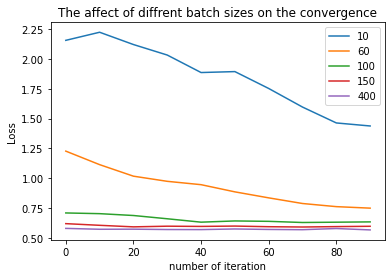

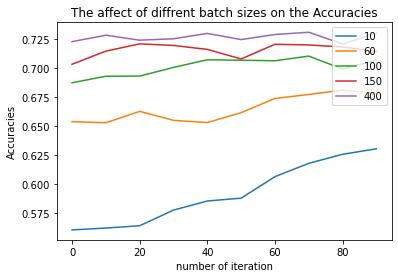

In [27]:
w0 = np.random.randn(90)
b0 = np.random.randn(1)[0]

# Write your code here
mu=0.6
batch_list=[10,60,100,150,400]
all_acc = []
all_losses = []
for batch_size in batch_list:
  print("batch_size=",batch_size,":")
  w,b,loss,accuracy=run_gradient_descent(w0,b0,mu,batch_size)
  print("~~~~~~~~~~~~~~~~~~~~~")
  all_acc.append(accuracy)
  all_losses.append(loss)
plt.figure()
for loss in all_losses:
  plt.plot(range(0,100,10),loss)
  plt.legend(batch_list,loc='upper right')
  plt.xlabel("number of iteration")
  plt.ylabel("Loss")
  plt.title("The affect of diffrent batch sizes on the convergence")
plt.show()

plt.figure()
for acc in all_acc:
  plt.plot(range(0,100,10),acc)
  plt.legend(batch_list,loc='upper right')
  plt.xlabel("number of iteration")
  plt.ylabel("Accuracies")
  plt.title("The affect of diffrent batch sizes on the Accuracies")

plt.show()

**Explain and discuss your results here:**
We chose $\mu=0.6$  because what we saw in the last saction (we got covergence and the covergence is not too slow). We can tell that the bigger the batch size we get fast convergence, which make sense because with bigger batches we need much fewer updates for the same accuracy. In addition, we can see that big batch size is not good time wise (As can be seen for 400,140,100).Notice that the accuracy increases as the betch increases.

However, even if it seems good to use a great batch size choosing too large of a betch size will lead to poor generalization. hence 100 or even 60 will be good for our model according to what we received.

Itamarrrrrrr

### Part (h) -- 15%

Using the values of `w` and `b` from part (g), compute your training accuracy, validation accuracy,
and test accuracy. Are there any differences between those three values? If so, why?

In [26]:
# Write your code here

desirable_w,desirable_b,_,_ = run_gradient_descent(w0,b0,0.6,150)

val_ys=pred(desirable_w,desirable_b,val_norm_xs)
train_ys=pred(desirable_w,desirable_b,train_norm_xs)
test_ys=pred(desirable_w,desirable_b,test_norm_xs)

train_acc = get_accuracy(train_ys,train_ts)
val_acc =  get_accuracy(val_ys,val_ts)
test_acc =  get_accuracy(test_ys,test_ts)

print('train_acc = ', train_acc, ' val_acc = ', val_acc, ' test_acc = ', test_acc)


0
Iter 10. [Val Acc 72%, Loss 0.585680]
Iter 20. [Val Acc 72%, Loss 0.581961]
Iter 30. [Val Acc 73%, Loss 0.574999]
Iter 40. [Val Acc 72%, Loss 0.583652]
Iter 50. [Val Acc 73%, Loss 0.574200]
Iter 60. [Val Acc 72%, Loss 0.572719]
Iter 70. [Val Acc 73%, Loss 0.579133]
Iter 80. [Val Acc 73%, Loss 0.570959]
Iter 90. [Val Acc 72%, Loss 0.575507]
Iter 100. [Val Acc 72%, Loss 0.583438]
train_acc =  0.7176196173694451  val_acc =  0.71908  test_acc =  0.7140034863451482


**Explain and discuss your results here:**
The train accuracy is a little bit better then the test_accuracy because the test data is an unseen data so it is very likely have lower accuracy on an unseen test dataset. Notice that the differnce here are not so great, it is a good sign ---> it mean that the model is well generalized.

Val accuracy should be some where between test and train accuracy - it is unseen data but we use the validation set for model selection so we did choose our parameters so the val_acc will be as good as the train_acc. Therefore, the results of the validation and the train are similar. 

### Part (i) -- 15%

Writing a classifier like this is instructive, and helps you understand what happens when
we train a model. However, in practice, we rarely write model building and training code
from scratch. Instead, we typically use one of the well-tested libraries available in a package.

Use `sklearn.linear_model.LogisticRegression` to build a linear classifier, and make predictions about the test set. Start by reading the
[API documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

Compute the training, validation and test accuracy of this model.

In [31]:
import sklearn.linear_model

model = sklearn.linear_model.LogisticRegression()
model.fit(train_norm_xs,train_ts)
train_ys=model.predict(train_norm_xs)
test_ys=model.predict(test_norm_xs)
val_ys=model.predict(val_norm_xs)

train_acc = get_accuracy(train_ys,train_ts)
val_acc =  get_accuracy(val_ys,val_ts)
test_acc =  get_accuracy(test_ys,test_ts)
print('train_acc = ', train_acc, ' val_acc = ', val_acc, ' test_acc = ', test_acc)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train_acc =  0.7326178649553436  val_acc =  0.73348  test_acc =  0.7267092775518109


**This parts helps by checking if the code worked.**
**Check if you get similar results, if not repair your code**


In [32]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
pandoc set to manually installed.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  javascript-common libcupsfilters1 libcupsimage2 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpotrace0 libptexenc1
  libruby2.5 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto apache2 | lighttpd | httpd poppler-utils ghostscript
  fonts-japanese-mincho | fonts-ipa

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
cp drive/My Drive/Colab Notebooks/Untitled.ipynb ./ use !cp "./drive/My Drive/Colab Notebooks/Copy of Assignment1 (1).ipynb" ./

cp: cannot stat 'drive/My': No such file or directory
cp: cannot stat 'Drive/Colab': No such file or directory
cp: cannot stat 'Notebooks/Untitled.ipynb': No such file or directory
cp: -r not specified; omitting directory './'
cp: cannot stat 'use': No such file or directory
cp: cannot stat '!cp': No such file or directory


In [35]:
!jupyter nbconvert --to PDF "Copy of Assignment1 (1).ipynb"

[NbConvertApp] Converting notebook Copy of Assignment1 (1).ipynb to PDF
[NbConvertApp] Support files will be in Copy of Assignment1 (1)_files/
[NbConvertApp] Making directory ./Copy of Assignment1 (1)_files
[NbConvertApp] Making directory ./Copy of Assignment1 (1)_files
[NbConvertApp] Making directory ./Copy of Assignment1 (1)_files
[NbConvertApp] Writing 105905 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./notebook.tex', '-quiet']
[NbConvertApp] CRITICAL | xelatex failed: [u'xelatex', u'./notebook.tex', '-quiet']
This is XeTeX, Version 3.14159265-2.6-0.99998 (TeX Live 2017/Debian) (preloaded format=xelatex)
 restricted \write18 enabled.
entering extended mode
(./notebook.tex
LaTeX2e <2017-04-15>
Babel <3.18> and hyphenation patterns for 3 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/lat